In [1]:
import os
import sys
maindir = os.getcwd()
sys.path.append(maindir+"/src")

In [2]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt

from preprocessing import data_processing, compute_anomalies, extract_longitude_latitude, \
                            compute_forced_response, compute_variance, \
                            merge_runs, stack_runs, numpy_to_torch, standardize, build_training_and_test_sets

from leave_one_out import leave_one_out_single, leave_one_out_procedure
from cross_validation import cross_validation_procedure

In [3]:
############### Load climate model raw data for SST
with open('data/ssp585_time_series.pkl', 'rb') as f:
    data = pickle.load(f)

###################### Load longitude and latitude 
with open('data/lon.npy', 'rb') as f:
    lon = np.load(f)

with open('data/lat.npy', 'rb') as f:
    lat = np.load(f)

# define grid (+ croping for latitude > 60)
lat_grid, lon_grid = np.meshgrid(lat[lat<=60], lon, indexing='ij')

lat_size = lat_grid.shape[0]
lon_size = lon_grid.shape[1]

In [4]:
# define pytorch precision
dtype = torch.float32

data_processed, notnan_idx, nan_idx = data_processing(data, lon, lat,max_models=100)
x = compute_anomalies(data_processed, lon_size, lat_size, nan_idx, time_period=33)
y = compute_forced_response(data_processed, lon_size, lat_size, nan_idx, time_period=33)
vars = compute_variance(x, lon_size, lat_size, nan_idx, time_period=33)

# convert numpy arrays to pytorch 
x, y, vars = numpy_to_torch(x,y,vars)

# standardize data 
x, y = standardize(x,y,vars)

# stack runs for each model
x, y, vars = stack_runs(x,y,vars,time_period=33,lon_size=lon_size,lat_size=lat_size,dtype=dtype)

# convert all data to pytorch tensors with precision float32
# x = {key: elt.to(torch.float16) for key, elt in x.items()}
# y = {key: elt.to(torch.float16) for key, elt in y.items()}
# vars = {key: elt.to(torch.float16) for key, elt in vars.items()}

# stack runs for each model
x_merged, y_merged, vars_merged = merge_runs(x,y,vars)

/home/vcohen/cope/src/preprocessing.py:109: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp,axis=1)
/home/vcohen/cope/src/preprocessing.py:110: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(mean_ref_ensemble,axis=0)
/home/vcohen/cope/src/preprocessing.py:152: RuntimeWarning: Mean of empty slice
  mean_spatial_ensemble = np.nanmean(y_tmp,axis=0)
/home/vcohen/cope/src/preprocessing.py:156: RuntimeWarning: Mean of empty slice
  data_forced_response[m][r] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble,axis=0)


In [5]:
m0 = 'CMCC-CM2-SR5'

training_models, x_train, y_train, x_test, y_test = build_training_and_test_sets(m0,x,y,vars,lon_size,lat_size,time_period=33,dtype=dtype)

In [6]:
from algorithms import ridge_regression, ridge_regression_low_rank, low_rank_projection, \
                        prediction, train_robust_weights_model, compute_weights


In [7]:
# compute ridge regressor
W_ridge = torch.zeros(lon_size*lat_size,lon_size*lat_size,dtype=dtype)
W_ridge[np.ix_(notnan_idx,notnan_idx)] = ridge_regression(x_train[:,notnan_idx], y_train[:,notnan_idx], lambda_=50.0, dtype=dtype)

# compute low rank ridge regressor
r = 70
W_rrr = torch.zeros(lon_size*lat_size,lon_size*lat_size,dtype=dtype)
W_rrr[np.ix_(notnan_idx,notnan_idx)] = ridge_regression_low_rank(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=50.0, dtype=dtype)

# compute low rank ridge regressor
r = 10
W_rrr = torch.zeros(lon_size*lat_size,lon_size*lat_size,dtype=dtype)
W_rrr[np.ix_(notnan_idx,notnan_idx)] = ridge_regression_low_rank(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=50.0, dtype=dtype)

# compute low rank ridge regressor
r = 5
W_rrr = torch.zeros(lon_size*lat_size,lon_size*lat_size,dtype=dtype)
W_rrr[np.ix_(notnan_idx,notnan_idx)] = ridge_regression_low_rank(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=50.0, dtype=dtype)

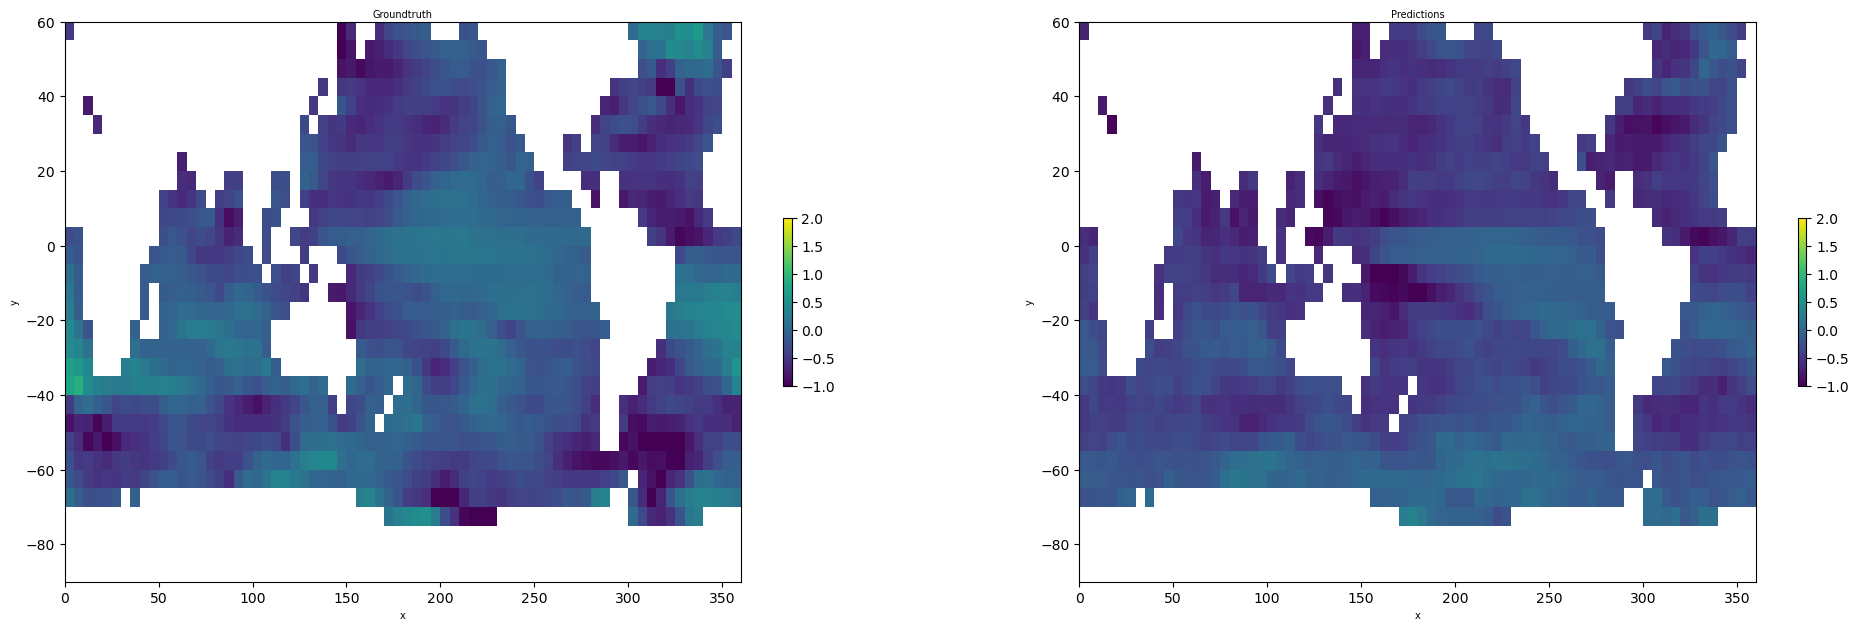

In [8]:
from plot_tools import plot_gt_vs_pred, animation_gt_vs_pred

plot_gt_vs_pred(y_test,x_test,W_ridge,notnan_idx,nan_idx,lon_grid,lat_grid,time_idx=10)

In [9]:
w_robust  = train_robust_weights_model(training_models,x,y,lon_size,lat_size,notnan_idx,\
                                                       rank=10,lambda_=100.0,mu_=1000.0,\
                                                       lr=1e-5,nb_iterations=100,dtype=dtype)

/tmp/ipykernel_7871/1383609421.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(training_models, rotation=-90)


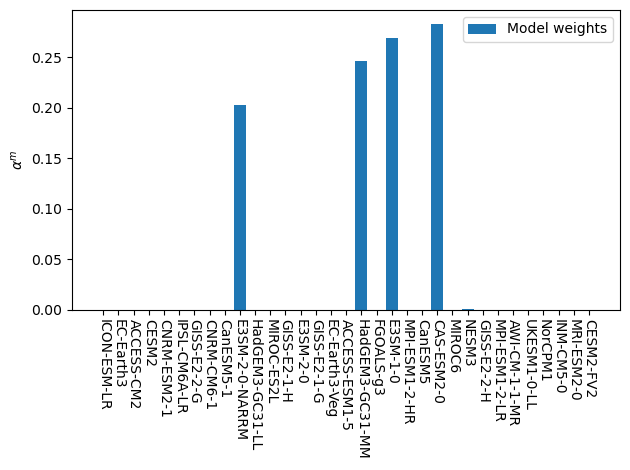

In [10]:
weights = compute_weights(training_models,w_robust,x,y,notnan_idx,lambda_=100.0,mu_=1000.0)

# plot the weights
    
################# plot the rmse #################
fig, ax = plt.subplots()
ax.bar(training_models, list(weights.values()),label='Model weights')
ax.set_ylabel(r'$\alpha^m$')
ax.legend()
ax.set_xticklabels(training_models, rotation=-90)
plt.tight_layout()
# plt.savefig("results/weights_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
plt.show()

In [11]:
# w_robust, y_pred, y_test, rmse_train = leave_one_out_single(m0,x,y,vars,\
#                                          lon_size,lat_size,notnan_idx,nan_idx,time_period=33,\
#                                          method='robust',rank=None,lambda_=100.0,mu_=1000.0,\
#                                          lr=1e-5,nb_gradient_iterations=5,verbose=True)

In [12]:
lambda_tmp = 100.0
mu_tmp = 1000.0
rank_tmp = 10

W_ridge, rmse_mean_ridge, weights_ridge = leave_one_out_procedure(x,y,vars,\
                                                                lon_size,lat_size, notnan_idx,nan_idx,time_period=33,\
                                                                method='ridge',rank=None,lambda_=lambda_tmp,mu_=mu_tmp,\
                                                                lr=1e-5,nb_gradient_iterations=50,verbose=True,dtype=dtype)

RMSE (mean) on model  ICON-ESM-LR  :  0.6552789050269181
RMSE (mean) on model  EC-Earth3  :  0.11117046822366265
RMSE (mean) on model  CMCC-CM2-SR5  :  0.23876542630756004
RMSE (mean) on model  ACCESS-CM2  :  0.22845238267291884
RMSE (mean) on model  CESM2  :  0.18085426189928905
RMSE (mean) on model  CNRM-ESM2-1  :  0.15061106384580655
RMSE (mean) on model  IPSL-CM6A-LR  :  0.09092662687862446
RMSE (mean) on model  GISS-E2-2-G  :  0.2457792479192995
RMSE (mean) on model  CNRM-CM6-1  :  0.0861740004134432
RMSE (mean) on model  CanESM5-1  :  0.09159550945209086
RMSE (mean) on model  E3SM-2-0-NARRM  :  1.1139187514298539
RMSE (mean) on model  HadGEM3-GC31-LL  :  0.08137634795588197
RMSE (mean) on model  MIROC-ES2L  :  0.07134520996523655
RMSE (mean) on model  GISS-E2-1-H  :  0.14279411852272905
RMSE (mean) on model  E3SM-2-0  :  0.10648764054390034
RMSE (mean) on model  GISS-E2-1-G  :  0.14288119217259734
RMSE (mean) on model  EC-Earth3-Veg  :  0.2580844797777592
RMSE (mean) on model  AC

In [ ]:
W_rrr, rmse_mean_rrr, training_loss_rrr, weights_rrr = leave_one_out_procedure(x,y,vars,\
                                                                            lon_size,lat_size, notnan_idx,nan_idx,time_period=33,\
                                                                            method='rrr',rank=10,lambda_=lambda_tmp,mu_=mu_tmp,\
                                                                            lr=1e-5,nb_gradient_iterations=50,verbose=True,dtype=dtype)

RuntimeError: expected m1 and m2 to have the same dtype, but got: double != float

In [ ]:
W_robust, rmse_mean_robust, weights_robust = leave_one_out_procedure(x,y,vars,\
                                                                    lon_size,lat_size, notnan_idx,nan_idx,time_period=33,\
                                                                    method='robust',rank=None,lambda_=lambda_tmp,mu_=mu_tmp,\
                                                                    lr=1e-5,nb_gradient_iterations=100,verbose=True)

RMSE (mean) on model  ICON-ESM-LR  :  0.548669159412384
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/vcohen/.conda/envs/cope/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_33413/2984266147.py", line 1, in <module>
    W_robust, rmse_mean_robust, weights_robust = leave_one_out_procedure(x,y,vars,\
  File "/home/vcohen/cope/src/leave_one_out.py", line 83, in leave_one_out_procedure
    w[m], y_pred[m], y_test[m] = leave_one_out_single(m,x,y,vars,\
  File "/home/vcohen/cope/src/leave_one_out.py", line 34, in leave_one_out_single
    w  = train_robust_weights_model(training_models,x,y,lon_size,lat_size,notnan_idx,rank,lambda_,mu_,lr,nb_iterations=nb_gradient_iterations,dtype=dtype)
  File "/home/vcohen/cope/src/algorithms.py", line 184, in train_robust_weights_model
  File "/home/vcohen/cope/src/algorithms.py", line 130, in compute_gradient
    res[idx_m][np.ix_(notnan_idx,notnan_idx)] = - 2*torch.mean(torch.bmm(torch.transpos

In [ ]:
W_robust_rrr, rmse_mean_robust_rrr, weights_robust_rrr = leave_one_out_procedure(x,y,vars,\
                                                                                    lon_size,lat_size, notnan_idx,nan_idx,time_period=33,\
                                                                                    method='robust',rank=10,lambda_=lambda_tmp,mu_=mu_tmp,\
                                                                                    lr=1e-5,nb_gradient_iterations=100,verbose=True)

In [ ]:
################### Ridge regresssion ########################
# compute the ridge loo
rmse_ridge_tmp =  np.array(list(rmse_mean_ridge.values()))

# worst loo Ridge
worst_loo_ridge = np.max(rmse_ridge_tmp)
mean_loo_ridge = np.mean(rmse_ridge_tmp)


# quantile 95, 90, 75
q_loo_95_ridge = np.quantile(rmse_ridge_tmp, 0.95)
q_loo_90_ridge = np.quantile(rmse_ridge_tmp, 0.90)
q_loo_75_ridge = np.quantile(rmse_ridge_tmp, 0.75)
q_loo_50_ridge = np.quantile(rmse_ridge_tmp, 0.5)


######################## compute the ridge rrr ######################
rmse_rrr_tmp =  np.array(list(rmse_mean_rrr.values()))

# worst loo Ridge
worst_loo_rrr = np.max(rmse_rrr_tmp)
mean_loo_rrr = np.mean(rmse_rrr_tmp)


# quantile 95, 90, 75
q_loo_95_rrr = np.quantile(rmse_rrr_tmp, 0.95)
q_loo_90_rrr = np.quantile(rmse_rrr_tmp, 0.90)
q_loo_75_rrr = np.quantile(rmse_rrr_tmp, 0.75)
q_loo_50_rrr = np.quantile(rmse_rrr_tmp, 0.5)


######################## compute the robust regression ######################
rmse_robust_tmp =  np.array(list(rmse_mean_robust.values()))

# worst loo Ridge
worst_loo_robust = np.max(rmse_robust_tmp)
mean_loo_robust = np.mean(rmse_robust_tmp)


# quantile 95, 90, 75
q_loo_95_robust = np.quantile(rmse_robust_tmp, 0.95)
q_loo_90_robust = np.quantile(rmse_robust_tmp, 0.90)
q_loo_75_robust = np.quantile(rmse_robust_tmp, 0.75)
q_loo_50_robust = np.quantile(rmse_robust_tmp, 0.5)

######################## compute the robust regression with low rank constraint ######################
rmse_robust_rrr =  np.array(list(rmse_mean_robust_rrr.values()))

# worst loo Ridge
worst_loo_robust_rrr = np.max(rmse_robust_rrr)
mean_loo_robust_rrr = np.mean(rmse_robust_rrr)


# quantile 95, 90, 75
q_loo_95_robust_rrr = np.quantile(rmse_robust_rrr, 0.95)
q_loo_90_robust_rrr = np.quantile(rmse_robust_rrr, 0.90)
q_loo_75_robust_rrr = np.quantile(rmse_robust_rrr, 0.75)
q_loo_50_robust_rrr = np.quantile(rmse_robust_rrr, 0.5)


print("======= Statistics ========")
print("\n")
print("          Ridge   RR-Lr   Robust  Robust-Lr")
print("Worst:    {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(worst_loo_ridge,worst_loo_rrr,worst_loo_robust, worst_loo_robust_rrr))
print("0.95:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_95_ridge,q_loo_95_rrr,q_loo_95_robust, q_loo_95_robust_rrr))
print("0.90:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_90_ridge,q_loo_90_rrr,q_loo_90_robust, q_loo_90_robust_rrr))
print("0.75:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_75_ridge,q_loo_75_rrr,q_loo_75_robust, q_loo_75_robust_rrr))
print("Median:   {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_50_ridge,q_loo_50_rrr,q_loo_50_robust, q_loo_50_robust_rrr))
print("Mean:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(mean_loo_ridge,mean_loo_rrr,mean_loo_robust, mean_loo_robust_rrr))

In [ ]:
# w, rmse, training_loss, weights = cross_validation_procedure(x,y,vars,\
#                                                            lon_size,lat_size,notnan_idx,nan_idx,time_period=33,\
#                                                            method='robust', rank=None, lambda_range=torch.tensor([100.0]), mu_range=torch.tensor([1000.0]),\
#                                                            lr=1e-5,nb_gradient_iterations=100,verbose=True)